# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Đồ án AI/Data"

/content/drive/MyDrive/Đồ án AI/Data


# Data Processing for DenseNet121, VGG16, ResNet50 and AlexNet

## Data Preprocessing

In [ ]:
# data_dir = '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset'
data_dir = "The IQ-OTHNCCD lung cancer dataset"
categories = ['begin', 'malignants', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Chuyển thành ảnh rgb
    img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)


print('Data length:', len(data))
print('labels counts:', Counter(labels))

X = np.array(data).reshape(-1, 224, 224, 3)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


## Split Data

In [ ]:
X_fold, X_valid, y_fold, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
# X,y valid are used for evaluate matrix

print('Train length:', len(X_fold), X_fold.shape)
print('Valid length:', len(X_valid), X_valid.shape)

Train length: 877 (877, 224, 224, 3)
Valid length: 220 (220, 224, 224, 3)


## Data Visualization

**NORMAL CASE**

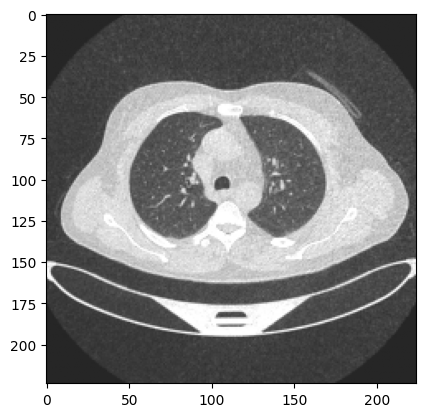

In [ ]:
plt.imshow(X[y==2][3])

**MAGLIGNANT CASE**

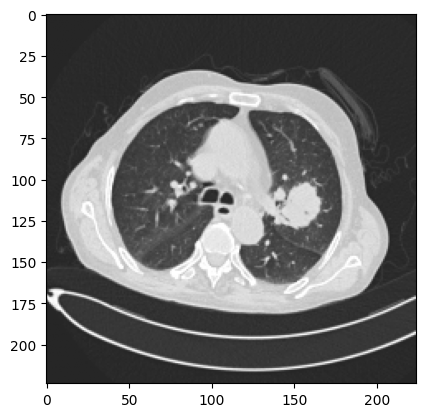

In [ ]:
plt.imshow(X[y==1][0])

**BENGIN CASE**

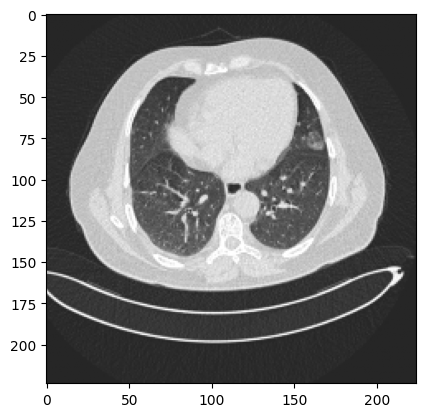

In [ ]:
plt.imshow(X[y==0][0])

# DenseNet121

## Build Model

In [ ]:
# Load pre-trained DenseNet121 model
DenseNetModel = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in DenseNetModel.layers:
    layer.trainable = False

# Add custom classification head
x = DenseNetModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model_denseNet = Model(inputs=DenseNetModel.input, outputs=output)

# model_denseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the modified model
model_denseNet.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

## Compile model

In [ ]:
model_denseNet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_denseNet = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_denseNet = model_denseNet.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_denseNet.history['accuracy'])
    valid_accuracy.extend(history_denseNet.history['val_accuracy'])
    model_loss.extend(history_denseNet.history['loss'])
    valid_loss.extend(history_denseNet.history['val_loss'])


Epoch 1/20
55/55 [==============================] - 27s 187ms/step - loss: 0.5799 - accuracy: 0.7662 - val_loss: 0.2723 - val_accuracy: 0.9375
Epoch 2/20
55/55 [==============================] - 4s 65ms/step - loss: 0.3016 - accuracy: 0.8974 - val_loss: 0.1740 - val_accuracy: 0.9432
Epoch 3/20
55/55 [==============================] - 4s 65ms/step - loss: 0.2307 - accuracy: 0.9156 - val_loss: 0.1332 - val_accuracy: 0.9545
Epoch 4/20
55/55 [==============================] - 4s 72ms/step - loss: 0.1900 - accuracy: 0.9282 - val_loss: 0.1488 - val_accuracy: 0.9659
Epoch 5/20
55/55 [==============================] - 4s 72ms/step - loss: 0.1549 - accuracy: 0.9441 - val_loss: 0.0844 - val_accuracy: 0.9773
Epoch 6/20
55/55 [==============================] - 4s 65ms/step - loss: 0.1592 - accuracy: 0.9418 - val_loss: 0.0973 - val_accuracy: 0.9886
Epoch 7/20
55/55 [==============================] - 4s 72ms/step - loss: 0.1696 - accuracy: 0.9373 - val_loss: 0.0930 - val_accuracy: 0.9830
Epoch 8/20


## Model Evaluation

In [ ]:
y_pred2 = model_denseNet.predict(X_valid, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_valid, y_pred_bool2))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool2))

7/7 [==============================] - 11s 709ms/step
              precision    recall  f1-score   support

           0       0.96      0.77      0.85        30
           1       0.99      0.98      0.99       117
           2       0.90      0.99      0.94        73

    accuracy                           0.95       220
   macro avg       0.95      0.91      0.93       220
weighted avg       0.96      0.95      0.95       220

[[ 23   1   6]
 [  0 115   2]
 [  1   0  72]]


## Model Visualization

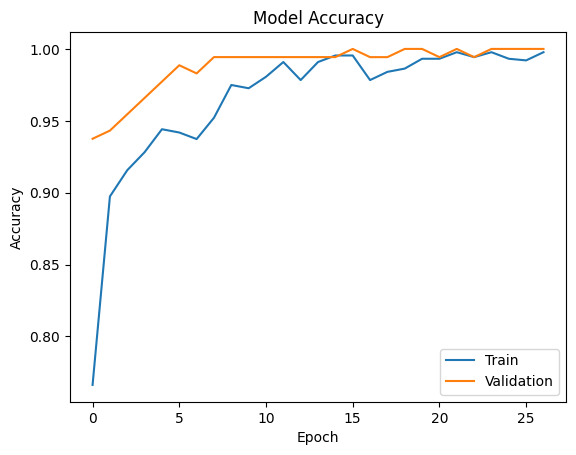

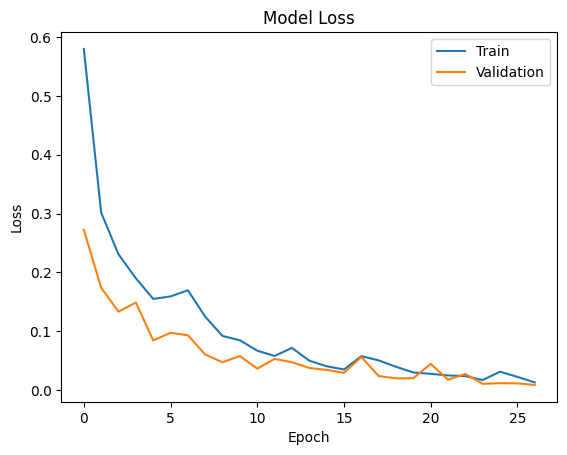

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# VGG16

## Build model

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the pre-trained layers so they are not updated during training
for layer in vgg.layers:
    layer.trainable = False



X=Flatten()(vgg.output)
X = Dense(256, activation='relu')(X)
prediction=Dense(3,activation="softmax")(X)
model_vgg=Model(inputs=vgg.input,outputs=prediction)

model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Compile model

In [ ]:
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_vgg = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_vgg = model_vgg.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_vgg.history['accuracy'])
    valid_accuracy.extend(history_vgg.history['val_accuracy'])
    model_loss.extend(history_vgg.history['loss'])
    valid_loss.extend(history_vgg.history['val_loss'])


Epoch 1/20
55/55 [==============================] - 17s 184ms/step - loss: 1.8792 - accuracy: 0.7127 - val_loss: 0.1969 - val_accuracy: 0.9432
Epoch 2/20
55/55 [==============================] - 5s 92ms/step - loss: 0.1573 - accuracy: 0.9361 - val_loss: 0.0719 - val_accuracy: 0.9886
Epoch 3/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0831 - accuracy: 0.9761 - val_loss: 0.0416 - val_accuracy: 1.0000
Epoch 4/20
55/55 [==============================] - 5s 90ms/step - loss: 0.0645 - accuracy: 0.9806 - val_loss: 0.0538 - val_accuracy: 0.9773
Epoch 5/20
55/55 [==============================] - 5s 90ms/step - loss: 0.0306 - accuracy: 0.9932 - val_loss: 0.0244 - val_accuracy: 0.9943
Epoch 6/20
55/55 [==============================] - 4s 79ms/step - loss: 0.0202 - accuracy: 0.9966 - val_loss: 0.0251 - val_accuracy: 0.9943
Epoch 1/20
55/55 [==============================] - 4s 80ms/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 2/20


## Model Evaluation

In [ ]:
y_pred2 = model_vgg.predict(X_valid, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_valid, y_pred_bool2))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool2))

7/7 [==============================] - 14s 1s/step


## Model visualization

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# ResNet50

## Build model

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

model_resnet = Sequential()


model_resnet.add(resnet_base)

model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(3, activation='softmax'))

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_26 (Dense)            (None, 128)               12845184  
                                                                 
 dense_27 (Dense)            (None, 3)                 387       
                                                                 
Total params: 36433283 (138.98 MB)
Trainable params: 12845571 (49.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


## Compile model

In [ ]:
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_resnet = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_resnet = model_resnet.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_resnet.history['accuracy'])
    valid_accuracy.extend(history_resnet.history['val_accuracy'])
    model_loss.extend(history_resnet.history['loss'])
    valid_loss.extend(history_resnet.history['val_loss'])


Epoch 1/50
103/103 [==============================] - 10s 60ms/step - loss: 2.2531 - accuracy: 0.5158 - val_loss: 0.8879 - val_accuracy: 0.5564
Epoch 2/50
103/103 [==============================] - 5s 52ms/step - loss: 0.8413 - accuracy: 0.6217 - val_loss: 0.8179 - val_accuracy: 0.6727
Epoch 3/50
103/103 [==============================] - 6s 54ms/step - loss: 0.7089 - accuracy: 0.6910 - val_loss: 0.7217 - val_accuracy: 0.6800
Epoch 4/50
103/103 [==============================] - 5s 49ms/step - loss: 0.7202 - accuracy: 0.6837 - val_loss: 0.6337 - val_accuracy: 0.6945
Epoch 5/50
103/103 [==============================] - 5s 51ms/step - loss: 0.5857 - accuracy: 0.7360 - val_loss: 0.5738 - val_accuracy: 0.7382
Epoch 6/50
103/103 [==============================] - 5s 49ms/step - loss: 0.5047 - accuracy: 0.7871 - val_loss: 0.6274 - val_accuracy: 0.6873
Epoch 7/50
103/103 [==============================] - 5s 53ms/step - loss: 0.4874 - accuracy: 0.7993 - val_loss: 0.4682 - val_accuracy: 0.792

## Model Evaluation

In [ ]:
y_pred2 = model_resnet.predict(X_valid, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_valid, y_pred_bool2))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool2))

9/9 [==============================] - 2s 89ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        35
           1       0.98      1.00      0.99       147
           2       1.00      0.99      0.99        93

    accuracy                           0.99       275
   macro avg       0.98      0.97      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 32   3   0]
 [  0 147   0]
 [  1   0  92]]


## Model visualization

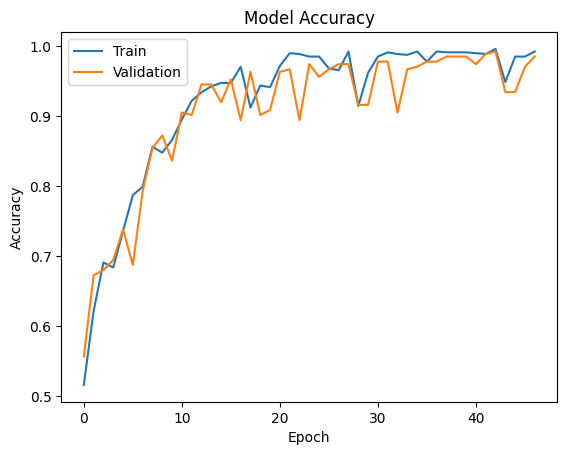

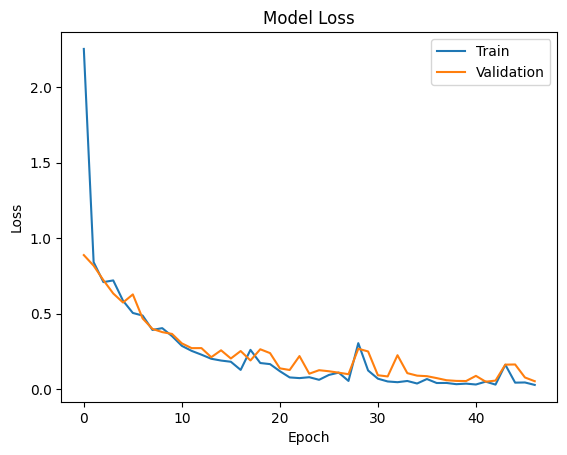

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Alexnet

## Build model

In [ ]:
def AlexNet(input_shape=(224,224,3)):
        inp = Input(input_shape)
        # 1st Convolutional Layer
        x = Conv2D(96,11,4, activation='relu', padding='valid',kernel_initializer='he_normal')(inp)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # 2st Convolutional Layer
        x = Conv2D(256,5,1, activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # 3st Convolutional Layer
        x = Conv2D(384,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # 4st Convolutional Layer
        x = Conv2D(384,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # 5st Convolutional Layer
        x = Conv2D(256,3,1,activation='relu', padding='valid',kernel_initializer='he_normal')(x)
        # Max Pooling
        x = MaxPooling2D(3,2)(x)
        # Passing it to a Fully Connected layer
        x = Flatten()(x)
        # 1st fully connected layer has 4096 neurons
        x = Dense(4096, activation='relu')(x)
        # Add Dropout to prevent overfitting
        x = Dropout(0.5)(x)
        # 2nd fully connected layer
        x = Dense(4096, activation='relu')(x)
        # Add dense and droupout
        x = Dropout(0.5)(x)
        # Output layer
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        return model

model_alexNet = AlexNet()
model_alexNet.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_99 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_100 (Conv2D)         (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 10, 10, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_101 (Conv2D)         (None, 8, 8, 384)         885

## Compile model

In [ ]:
model_alexNet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training model

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
history_alexNet = model_alexNet.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback], class_weight={class_index: weight for class_index, weight in enumerate(class_weights)})

Epoch 1/20
103/103 [==============================] - 5s 23ms/step - loss: 1.3394 - accuracy: 0.3187 - val_loss: 1.0869 - val_accuracy: 0.5345
Epoch 2/20
103/103 [==============================] - 2s 20ms/step - loss: 1.1048 - accuracy: 0.4367 - val_loss: 1.0995 - val_accuracy: 0.3382
Epoch 3/20
103/103 [==============================] - 3s 24ms/step - loss: 1.1001 - accuracy: 0.3260 - val_loss: 1.0090 - val_accuracy: 0.5636
Epoch 4/20
103/103 [==============================] - 3s 26ms/step - loss: 1.1102 - accuracy: 0.4161 - val_loss: 1.1063 - val_accuracy: 0.1309
Epoch 5/20
103/103 [==============================] - 2s 21ms/step - loss: 1.1161 - accuracy: 0.2835 - val_loss: 1.0751 - val_accuracy: 0.5345
Epoch 6/20
103/103 [==============================] - 2s 21ms/step - loss: 1.1093 - accuracy: 0.3516 - val_loss: 1.0645 - val_accuracy: 0.5345
Epoch 7/20
103/103 [==============================] - 2s 21ms/step - loss: 1.1080 - accuracy: 0.3090 - val_loss: 1.0936 - val_accuracy: 0.3382

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_denseNet = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    history_alexNet = model_alexNet.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback], class_weight={class_index: weight for class_index, weight in enumerate(class_weights)})
    model_accuracy.extend(history_alexNet.history['accuracy'])
    valid_accuracy.extend(history_alexNet.history['val_accuracy'])
    model_loss.extend(history_alexNet.history['loss'])
    valid_loss.extend(history_alexNet.history['val_loss'])


## Model Evaluation

In [ ]:
y_pred = model_alexNet.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.53      1.00      0.70       147
           2       0.00      0.00      0.00        93

    accuracy                           0.53       275
   macro avg       0.18      0.33      0.23       275
weighted avg       0.29      0.53      0.37       275

[[  0  35   0]
 [  0 147   0]
 [  0  93   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model visualization

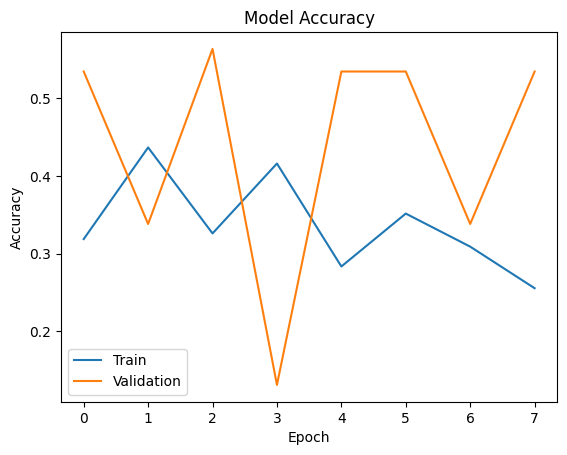

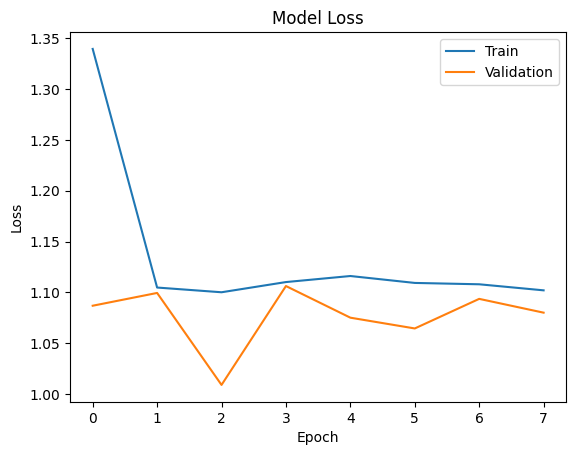

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# LeNet5

## Data Preprocessing

In [ ]:
data_dir = '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset'

categories = ['begin', 'malignants', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)

# Kiểm tra cân bằng dữ liệu
print('Data length:', len(data))
print('labels counts:', Counter(labels))

# normalize
X = np.array(data).reshape(-1, 32, 32, 1)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


## Data Preprocessing

In [ ]:
X_fold, X_valid, y_fold, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
# X,y valid are used for evaluate matrix

print('Train length:', len(X_fold), X_fold.shape)
print('Valid length:', len(X_valid), X_valid.shape)

Train length: 767 (767, 32, 32, 1)
Test length: 330 (330, 32, 32, 1)


## Build Lenet-5 Model

In [ ]:
def Lenet5(input_shape=(32,32,1)):
        # Input
        inp = Input(input_shape)
        # Conv1
        x = Conv2D(6, 5, activation='tanh')(inp)
        # Average Pooling 1
        x = AveragePooling2D(2, 2)(x)
        # Conv2
        x = Conv2D(16, 5, activation='tanh')(x)
        # Average Pooling 2
        x = AveragePooling2D(2, 2)(x)
        # Conv3
        x = Conv2D(120, 5, activation='tanh')(x)
        x = Flatten()(x)
        # Fully connected
        x = Dense(84, activation='tanh')(x)
        # Output
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs= inp, outputs=x)
        return model

model_lenet5 = Lenet5()
model_lenet5.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_32 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_33 (Conv2D)          (None, 1, 1, 120)         481

## Compile model

In [ ]:
model_lenet5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_lenet5 = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_lenet5 = model_lenet5.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_lenet5.history['accuracy'])
    valid_accuracy.extend(history_lenet5.history['val_accuracy'])
    model_loss.extend(history_lenet5.history['loss'])
    valid_loss.extend(history_lenet5.history['val_loss'])


## Model Evaluation

In [ ]:
y_pred = model_lenet5.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        39
           1       0.99      0.98      0.99       180
           2       0.97      0.95      0.96       111

    accuracy                           0.97       330
   macro avg       0.96      0.98      0.97       330
weighted avg       0.97      0.97      0.97       330

[[ 39   0   0]
 [  0 177   3]
 [  4   2 105]]


## Model visualization

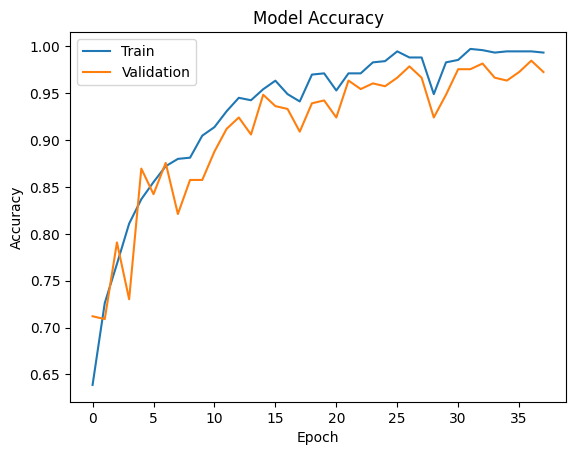

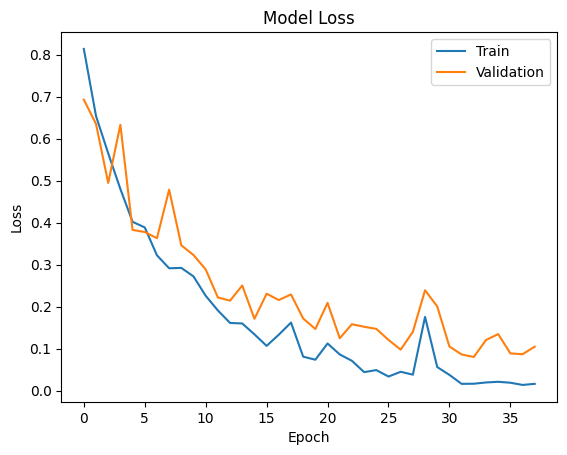

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()